In [8]:
import os
import numpy as np

In [9]:
path_to_series = os.path.join(".", "datasets", "ecg-heartbeat-av.csv")
f = open(path_to_series)
ts = np.array(f.readlines(), dtype=np.double)

fs = 128  # sampling frequency


In [10]:
# uncomment this code block for the multivariate ECG example:
path_to_series = os.path.join(".", "datasets", "mitdb_patient214.csv")
f = open(path_to_series)
ts = np.array([line.split(',') for line in f.readlines()], dtype=np.double)
fs = 360  # sampling frequency

In [11]:
if ts.ndim == 1:
    ts = np.expand_dims(ts, axis=1)
print(ts.shape)

(3600, 2)


In [12]:
# z-normalize time series
ts = (ts - np.mean(ts, axis=0)) / np.std(ts, axis=0)

# Parameter rho determines the 'strictness' of the algorithm  
#   - higher -> more strict (more similarity in discovered motif sets)
#   - lower  -> less strict (less similarity in discovered motif sets) 
rho = 0.6

# Number of motifs to be found
nb_motifs = 2

# Heartbeats last 0.6s - 1s (equivalent to 60-100 bpm)
l_min = int(0.6 * fs)
l_max = int(  1 * fs)

# This parameter determines how much the motifs may overlap (intra and inter motif set)
overlap = 0

In [13]:
import locomotif.locomotif as locomotif

In [14]:
lcm = locomotif.get_locomotif_instance(ts, l_min, l_max, rho=rho, warping=True)
# Apply LoCo
lcm.align()
lcm.find_best_paths(vwidth=l_min // 2)
# Find the `nb` best motif sets
motif_sets = []
for representative, motif_set, _ in lcm.find_best_motif_sets(nb=2, overlap=overlap):
    motif_sets.append((representative, motif_set))

representative, motif_set = motif_sets[0]
b, e = representative

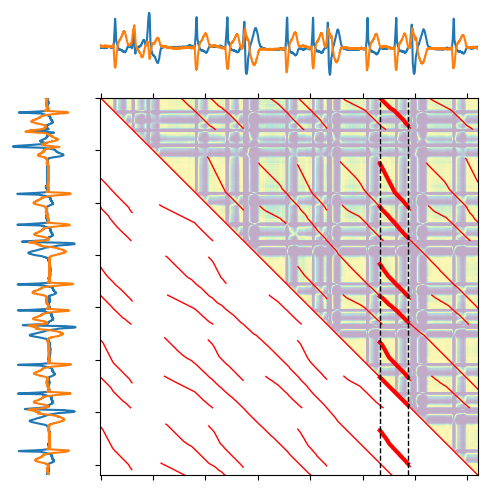

In [15]:
# b, e, fitness, coverage, score
import locomotif.visualize as visualize

fig, axs, _ = visualize.plot_sm(ts, ts, lcm._sm, matshow_kwargs={'alpha': 0.33})
visualize.plot_local_warping_paths(axs, lcm.get_paths(), lw=1)

induced_paths = lcm.induced_paths(b, e)
visualize.plot_local_warping_paths(axs, induced_paths, lw=3)

axs[3].axvline(b, lw=1, c='k', ls='--')
axs[3].axvline(e, lw=1, c='k', ls='--')

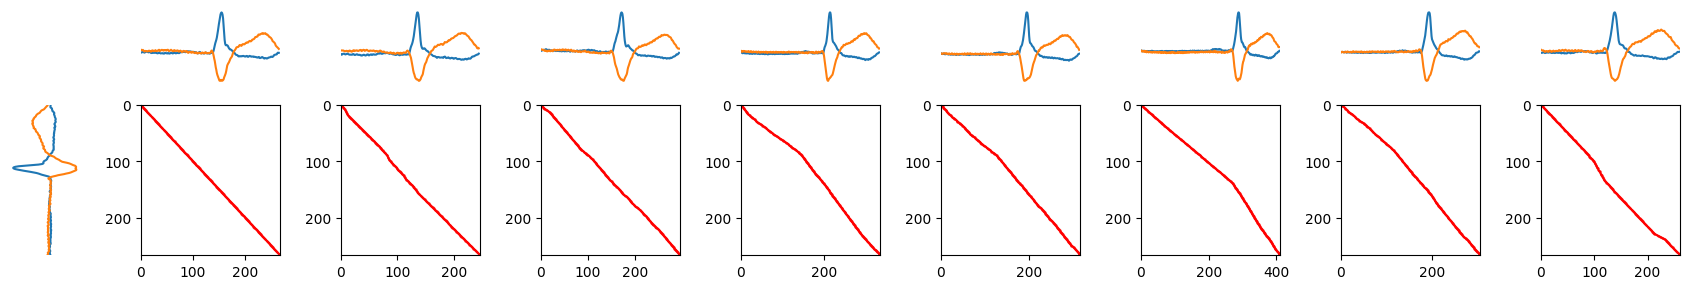

In [16]:
import matplotlib.pyplot as plt

k = len(motif_set)
fig, ax = plt.subplots(2, k+1, figsize=(2 * (0.5 + k), 2*1.5), width_ratios=[0.5] ++ k * [1], height_ratios=[0.5, 1])
ax[0, 0].set_axis_off()

ax[1, 0].plot(-ts[b:e, :], range(e-b), 0, -1)
ax[1, 0].set_ylim([-0.5, e-b+0.5])
ax[1, 0].set_axis_off()

for i, path in enumerate(induced_paths):
    (bm, em) = path[0][0], path[-1][0]
    
    ax[0, i+1].plot(ts[bm:em, :])
    ax[0, i+1].set_xlim([-0.5, em-bm+0.5])
    ax[0, i+1].set_axis_off()

    ax[1, i+1].invert_yaxis()
    ax[1, i+1].plot(path[:, 0]-bm, path[:, 1]-b, c='r', ls='-', marker='.', markersize=1)
    
    ax[1, i+1].set_ylim([e-b , 0])
    ax[1, i+1].set_xlim([0, em-bm])

plt.tight_layout()